#### Reading materials

+ wiki
  https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model

+ blogs
  https://richnewman.wordpress.com/2007/06/24/a-beginner%E2%80%99s-guide-to-the-black-scholes-option-pricing-formula-part-1/
  https://medium.com/cantors-paradise/the-black-scholes-formula-explained-9e05b7865d8a

#### repos

+ https://github.com/vollib/vollib 
+ py version https://github.com/vollib/py_vollib
+ https://github.com/boyac/pyOptionPricing

#### refs
+ yikes. https://jaeckel.000webhostapp.com/LetsBeRational.pdf


#### summary of below

+ below are scripts to try out vollib
+ see how computed call put price derived using black's formula compares against actual call put prices.

In [249]:
import datetime
import numpy as np
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [250]:
from py_vollib.ref_python.black_scholes_merton import black_scholes_merton

In [251]:
symbol = 'SPY'
tick = yf.Ticker(symbol)
history = tick.history(period='max')
underlying_asset_price = tick.info['regularMarketPrice']

In [252]:
# tick.info

In [253]:
expiry = tick.options[10]
print(expiry)
oc = tick.option_chain(expiry)
print(oc.puts.shape)

2020-12-11
(124, 14)


In [268]:
pdf = oc.puts
print(pdf.shape)
pdf = pdf[
    (pdf['lastPrice']!=0)
]
pdf = pdf.sort_values('lastPrice',ascending=False)
print(pdf.shape)
print(pdf.columns)

(107, 14)
(107, 14)
Index(['contractSymbol', 'lastTradeDate', 'strike', 'lastPrice', 'bid', 'ask',
       'change', 'percentChange', 'volume', 'openInterest',
       'impliedVolatility', 'inTheMoney', 'contractSize', 'currency'],
      dtype='object')


In [278]:
row = pdf.iloc[0]
print(row)

contractSymbol        SPY201130P00390000
lastTradeDate        2020-11-16 05:03:14
strike                               390
lastPrice                          37.04
bid                                    0
ask                                    0
change                                 0
percentChange                          0
volume                               NaN
openInterest                           0
impliedVolatility                  1e-05
inTheMoney                          True
contractSize                     REGULAR
currency                             USD
Name: 106, dtype: object


In [279]:
expiry_dt = datetime.datetime.strptime(expiry,'%Y-%m-%d').date()
today_dt = datetime.datetime.now().date()
time_to_expiry_years = (expiry_dt-today_dt).days/356
print(time_to_expiry_years)

2.2219101123595504


In [280]:
# annualized realize volatility.
log_ret = np.log(history.Close) - np.log(history.Close.shift(1))
hist_volatility = log_ret.rolling(21).std()*np.sqrt(252)*100
mysig = hist_volatility.iloc[-1:].values[0]/100

In [281]:
# http://vollib.org/documentation/python/1.0.2/apidoc/py_vollib.ref_python.black_scholes_merton.html
# py_vollib.ref_python.black_scholes_merton.black_scholes_merton(flag, S, K, t, r, sigma, q)[source]
# 
#S (float) – underlying asset price
#K (float) – strike price
#sigma (float) – annualized standard deviation, or volatility
#t (float) – time to expiration in years
#r (float) – risk-free interest rate
#q (float) – annualized continuous dividend rate
#flag (str) – ‘c’ or ‘p’ for call or put.

In [282]:
print(underlying_asset_price)
print(row.strike)
print(time_to_expiry_years)
print(mysig)
print(row.lastPrice)

355.6
390.0
2.2219101123595504
0.220855562475327
37.04


In [283]:
S = underlying_asset_price
K = row.strike
q = 0
t = time_to_expiry_years
r = 0
sigma = mysig
p_published_value = row.lastPrice
p_calc = black_scholes_merton('p', S, K, t, r, sigma, q)
print(p_published_value,p_calc)

37.04 67.82770890943357


In [284]:
print(underlying_asset_price)

355.6


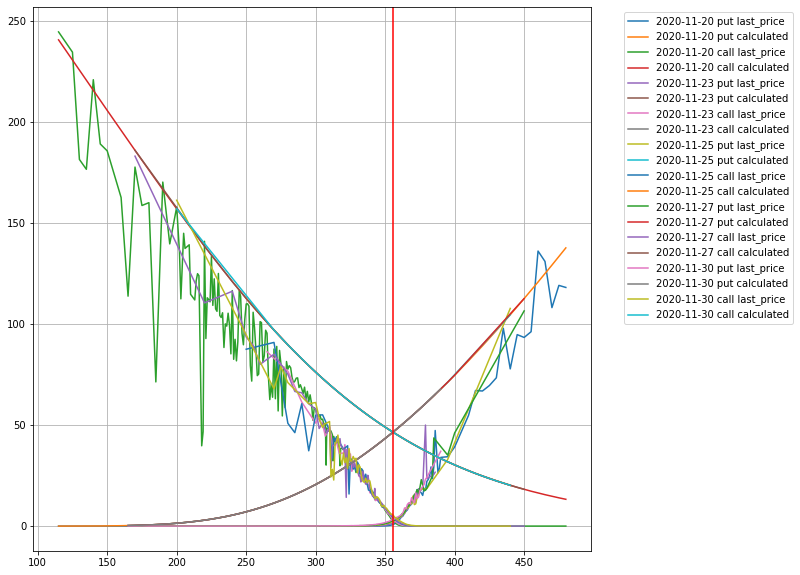

In [286]:
plt.figure(figsize=(10,10))
c = 0
for expiry in tick.options:
    c+=1
    if c > 5:
        continue
    #expiry = tick.options[10]
    #print(expiry)
    oc = tick.option_chain(expiry)
    #print(oc.calls.shape)
    #print(oc.puts.shape)

    pdf = oc.puts
    #print(pdf.shape)
    pdf = pdf[
        (pdf['lastPrice']!=0)
    ]
    #print(pdf.shape)

    if pdf.shape[0] == 0:
        continue
    
    cdf = oc.calls
    #print(cdf.shape)
    cdf = cdf[
        (cdf['lastPrice']!=0)
    ]
    #print(cdf.shape)
    
    if cdf.shape[0] == 0:
        continue

        
    pdata = []
    for n,row in pdf.iterrows():
        S = underlying_asset_price
        K = row.strike
        q = 0
        t = time_to_expiry_years
        r = 0
        sigma = mysig
        p_calc = black_scholes_merton('p', S, K, t, r, sigma, q)
        item=dict(
            K=K,L=row.lastPrice,E=p_calc
        )
        pdata.append(item)
    mypdf=pd.DataFrame(pdata)
    mypdf = mypdf.sort_values('K')

        
    cdata = []
    for n,row in cdf.iterrows():
        S = underlying_asset_price
        K = row.strike
        q = 0
        t = time_to_expiry_years
        r = 0
        sigma = mysig
        p_calc = black_scholes_merton('c', S, K, t, r, sigma, q)
        item=dict(
            K=K,L=row.lastPrice,E=p_calc
        )
        cdata.append(item)
    mycdf=pd.DataFrame(cdata)
    mycdf = mycdf.sort_values('K')


    plt.plot(mypdf.K,mypdf.L,label=f'{expiry} put last_price')
    plt.plot(mypdf.K,mypdf.E,label=f'{expiry} put calculated')

    plt.plot(mycdf.K,mycdf.L,label=f'{expiry} call last_price')
    plt.plot(mycdf.K,mycdf.E,label=f'{expiry} call calculated')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.axvline(underlying_asset_price,color='red')

In [3]:
from py_vollib.ref_python.black_scholes_merton import black_scholes_merton
from py_vollib.ref_python.black_scholes_merton.greeks.analytical import delta

#https://github.com/vollib/py_vollib/blob/master/py_vollib/black_scholes_merton/greeks/analytical.py
#def delta(flag, F, K, t, r, sigma):
#    """Returns the Black delta of an option.